**Read this Paper:** https://arxiv.org/pdf/1708.02182v1.pdf which achieved 93% accuracy. 

In [51]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras

In [62]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    ax[0].plot(history.history["loss"], label="loss")
    ax[0].plot(history.history["val_loss"], label="val_loss")
    ax[0].legend()
    
    ax[1].plot(history.history["acc"], label="acc")
    ax[1].plot(history.history["val_acc"], label="val_acc")
    ax[1].legend()
    return None

In [2]:
INP_DIR = "data/data_"

In [6]:
reviews_train = pd.read_csv(os.path.join(INP_DIR, "reviews_train.csv"))
reviews_val = pd.read_csv(os.path.join(INP_DIR, "reviews_val.csv"))
reviews_test = pd.read_csv(os.path.join(INP_DIR, "reviews_test.csv"))

y_train = reviews_train["sentiment"].values
y_val = reviews_val["sentiment"].values
y_test = reviews_test["sentiment"].values

reviews_train.shape, reviews_val.shape, reviews_test.shape

((32000, 2), (8000, 2), (10000, 2))

# Word embedding + a hidden dense layer

In [142]:
MAX_WORDS_PER_DOC = 200
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 200), (8000, 200), (10000, 200))

In [145]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 1e-3
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               10000500  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,050,801
Trainable params: 12,050,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
500/500 [==============================] - 8s 15ms/step - loss: 0.3837 - acc: 0.8167 - val_lo

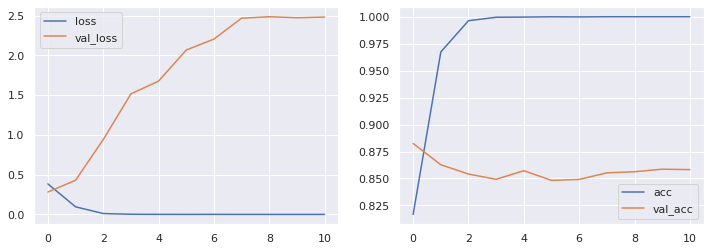

In [146]:
plot_history(history)

In [147]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8786


# Word embedding + LSTM layers

In [148]:
MAX_WORDS_PER_DOC = 200
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 200), (8000, 200), (10000, 200))

In [152]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100))

model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 1e-3
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,241,401
Trainable params: 2,241,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
500/500 [==============================] - 27s 54ms/step - loss: 0.6532 - acc: 0.5819 - val_los

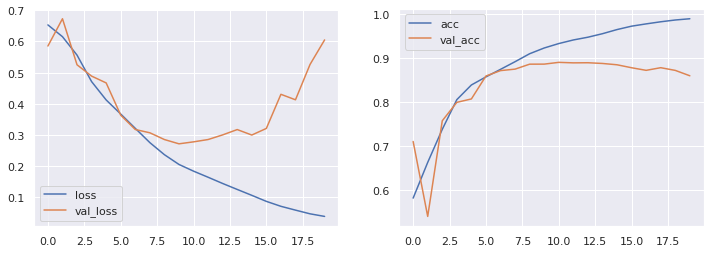

In [153]:
plot_history(history)

In [154]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8894


The last LSTM layer returns the whole sequence and is flatten before connected to the output layer. 

In [156]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100, return_sequences=True))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 5e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 2,261,301
Trainable params: 2,261,301
Non-trainable params: 0
______________________________________________

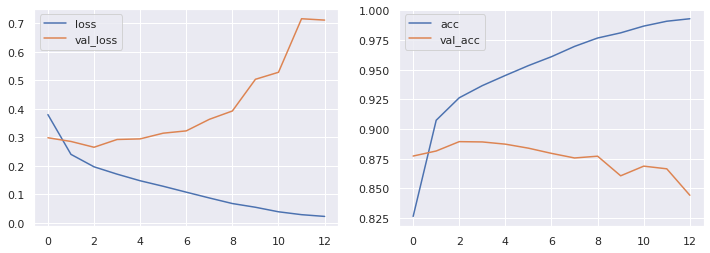

In [157]:
plot_history(history)

In [158]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8872


# Word Embedding + 1D CNN layers

In [174]:
MAX_WORDS_PER_DOC = 400
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 400), (8000, 400), (10000, 400))

In [175]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))

model.add(keras.layers.Conv1D(filters=200, kernel_size=8, padding="valid", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 1e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          2000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 393, 200)          160200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 200)          0         
_________________________________________________________________
flatten (Flatten)            (None, 39200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 39201     
Total params: 2,199,501
Trainable params: 2,199,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
500/500 [==============================] - 13s 27ms/step - loss: 0.6459 - acc: 0.6350 - val_los

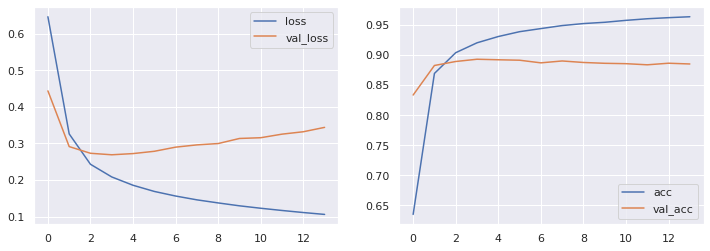

In [176]:
plot_history(history)

In [177]:
_, test_val = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8872


# Word embedding + LSTM + Conv1D

In [178]:
MAX_WORDS_PER_DOC = 400
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 400), (8000, 400), (10000, 400))

In [179]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))

model.add(keras.layers.LSTM(200, return_sequences=True))

model.add(keras.layers.Conv1D(filters=200, kernel_size=8, padding="valid", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 5e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 400, 200)          240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 393, 200)          320200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 200)          0         
_________________________________________________________________
flatten (Flatten)            (None, 39200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 39201     
Total params: 2,600,301
Trainable params: 2,600,301
Non-trainable params: 0
______________________________________________

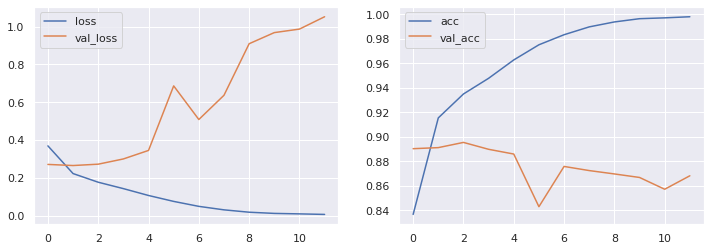

In [180]:
plot_history(history)

In [181]:
_, test_val = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8872
